In [1]:
import os
import sys
import json
import argparse
from time import time
from functools import partial

import numpy as np
import pandas as pd

from tqdm import tqdm

from sklearn.preprocessing import normalize
from sklearn.random_projection import GaussianRandomProjection
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors

from rsq.samplers import *
from rsq.samplers import _Sampler
from rsq.helpers import set_seeds

from rsq import SVCEnsemble, AgglomerativeEnsemble, AgglomerativeClassifier
from rsq.agglomerative_helpers import get_tree_distances, get_decision_paths

from joblib import Parallel, delayed

import torchvision

import pickle

def stratified_sample(y, p=0.67, replace=False):
    unique_y, counts = np.unique(y, return_counts=True)
    n_per_class = np.array([int(np.math.floor(p*c)) for c in counts])
    n_per_class = np.array([max([npc, 1]) for npc in n_per_class])
    
    inds = [np.random.choice(np.where(y == unique_y[i])[0], size=npc, replace=replace) for i, npc in enumerate(n_per_class)]
    
    return np.concatenate(inds)

def few_shot_sample(y, n_samples_per_class=1):
    unique_y = np.unique(y)    
    inds = [np.random.choice(np.where(y == c)[0], size=n_samples_per_class, replace=False) for c in unique_y]
    
    return np.concatenate(inds)

In [2]:
#- Data processing 1

class Dataset:
    def __init__(self, file='cifar_100_Bit_m-r101x1_embd.p', train=True, classes=[]):
        if train:
            self.data = pickle.load(open(file, 'rb'))[0][0]
            self.targets = np.concatenate(pickle.load(open(file, 'rb'))[0][1])
        else:
            self.data = pickle.load(open(file, 'rb'))[1][0]
            self.targets = np.concatenate(pickle.load(open(file, 'rb'))[1][1])
        
        self.classes = classes

In [3]:
#- Data processing 2

cif100 = torchvision.datasets.CIFAR100(root='./data', train=True, download=True)

file='../../../../data/cifar_100_Bit_m-r101x1_embd.p'
trainset = Dataset(file, train=True, classes=cif100.classes)
testset = Dataset(file, train=False, classes=cif100.classes)

Files already downloaded and verified


In [4]:
coarse_to_fine_map = {
'aquatic_mammals': ['beaver', 'dolphin', 'otter', 'seal', 'whale'],
'fish': ['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout'],
'flowers': ['orchid', 'poppy', 'rose', 'sunflower', 'tulip'],
'food_containers': ['bottle', 'bowl', 'can', 'cup', 'plate'],
'fruit_and_vegetables': ['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper'],
'household_electrical_devices': ['clock', 'keyboard', 'lamp', 'telephone', 'television'],
'household_furniture': ['bed', 'chair', 'couch', 'table', 'wardrobe'],
'insects': ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
'large_carnivores': ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
'large_man-made_outdoor_things': ['bridge', 'castle', 'house', 'road', 'skyscraper'],
'large_natural_outdoor_scenes': ['cloud', 'forest', 'mountain', 'plain', 'sea'],
'large_omnivores_and_herbivores': ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'],
'medium-sized_mammals': ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
'non-insect_invertebrates': ['crab', 'lobster', 'snail', 'spider', 'worm'],
'people': ['baby', 'boy', 'girl', 'man', 'woman'],
'reptiles': ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
'small mammals': ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
'trees': ['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree'],
'vehicles_1': ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train'],
'vehicles_2': ['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor']
}

coarse_number_to_coarse_name = {i: name for i, name in enumerate(coarse_to_fine_map)}

def fine_to_coarse(coarse_to_fine):
    fine_to_coarse_map = {}
    for key in coarse_to_fine:
        fines = coarse_to_fine[key]
        for f in fines:
            fine_to_coarse_map[f] = key
            
    return fine_to_coarse_map

fine_to_coarse_map = fine_to_coarse(coarse_to_fine_map)

fine_number_to_fine_name = {i: name for i, name in enumerate(trainset.classes)}
fine_name_to_fine_number = {name: i for i, name in fine_number_to_fine_name.items()}

for i in range(100):
    fine_to_coarse_map[fine_number_to_fine_name[i]]
    
coarse_name_to_coarse_number = {name: i for i, name in enumerate(coarse_to_fine_map)}

coarse_targets = np.array([coarse_name_to_coarse_number[fine_to_coarse_map[fine_number_to_fine_name[y]]] for y in trainset.targets])
idx_by_coarse = np.array([np.where(coarse_targets == y)[0] for y in range(20)])
idx_by_fine = np.array([np.where(trainset.targets == y)[0] for y in range(100)])


test_coarse_targets = np.array([coarse_name_to_coarse_number[fine_to_coarse_map[fine_number_to_fine_name[y]]] for y in testset.targets])
test_idx_by_coarse = np.array([np.where(test_coarse_targets == y)[0] for y in range(20)])


coarse_names = np.array(list(coarse_name_to_coarse_number.keys()))

fine_number_to_coarse_number = {fn: coarse_name_to_coarse_number[
                                        fine_to_coarse_map[
                                            fine_number_to_fine_name[fn]
                                        ]
                                    ] for fn in range(100)}


fine_by_coarse = [np.where(np.array(list(fine_number_to_coarse_number.values())) == i)[0] for i in range(20)]
all_fine = np.concatenate(fine_by_coarse)

In [5]:
from sklearn.svm import LinearSVC

def ssl_exp(X, y, n_samples_per_class=1, acorn=None):    
    inds_sup = few_shot_sample(y, n_samples_per_class)
    inds_unsup = np.array([i for i in range(len(y)) if i not in inds_sup]).astype(int)
    X=X.copy()

    y_ = -1 * np.ones(n)
    y_[inds_sup] = y[inds_sup]
    
    #- 2 = Supervised, Semisupervised
    accs = np.zeros(2)
    times = np.zeros(2)
        
    
    print("begin fit2")
    #- Semi-Supervised
    svc_semisup = AgglomerativeEnsemble(n_estimators=1, p_inbag=1, 
                                        projector=None, projection_kwargs={'n_components': 64}, 
                                        affinity='euclidean', linkage='average', max_tree_distance=400)
    time_ = time()
    svc_semisup.fit(X, y_)
    
    accs[1] = (svc_semisup.predict(X[inds_unsup]) == y[inds_unsup]).mean()
    times[1] = time() - time_
    
    print("finish fit+predict 2 in", times[1], "seconds")
    time_ = time()
    
    
    print("begin fit1")
    #- Supervised
    svc_sup = LinearSVC(C=1)
    time_ = time()
    svc_sup.fit(X[inds_sup], y[inds_sup])
    accs[0] = (svc_sup.predict(X[inds_unsup]) == y[inds_unsup]).mean()
    times[0] = time() - time_
    print("finish fit+predict 1 in", times[0], "seconds")
        
    return accs, times

In [7]:
np.random.seed(1)

n_samples_per_class=[1]
n_cores=40
# n_mc=int(n_cores / len(prop_labeled))
n_mc=1

experiment_tuples = []

for i, p in enumerate(n_samples_per_class):
    for _ in range(n_mc):
        all_inds = stratified_sample(trainset.targets, p=0.5, replace=False)
        n=len(all_inds)
        
        experiment_tuples.append((trainset.data[all_inds], trainset.targets[all_inds], p))
    

condensed_func = lambda x: ssl_exp(*x)
start_time = time()
print(len(experiment_tuples))
# try:
#     accuracies_and_times = Parallel(n_jobs=n_cores)(delayed(condensed_func)(tupl) for tupl in experiment_tuples)
#     print("finished in %1.1f"%(time() - start_time))
# except:
#     print("error after %1.1f"%(time() - start_time))
#     assert 0 == 1

1


In [8]:
X,y,n_samples_per_class = experiment_tuples[0]

In [9]:
inds_sup = few_shot_sample(y, n_samples_per_class)
inds_unsup = np.array([i for i in range(len(y)) if i not in inds_sup]).astype(int)

y_ = -1 * np.ones(n)
y_[inds_sup] = y[inds_sup]

In [10]:
def benchmark_agg_class(X, y, inds_sup, kwargs):
    inds_unsup = np.array([i for i in range(len(y)) if i not in inds_sup]).astype(int)

    y_ = -1 * np.ones(n)
    y_[inds_sup] = y[inds_sup]
    
    agg_class = AgglomerativeEnsemble(**kwargs)
    fit_time_ = time()
    agg_class.fit(X, y_)
    fit_time = time() - fit_time_
    
    inf_time_ = time()
    accuracy = (agg_class.predict(X[inds_unsup]) == y[inds_unsup]).mean()
    inf_time = time() - inf_time_
    
    print(accuracy, fit_time, inf_time)
    
    return accuracy, fit_time, inf_time

benchmark = lambda x: benchmark_agg_class(X, y, inds_sup, x)

In [29]:
n_components_list = [1,4,16,64,256,1024]

f_tuples = []
for i, n_components in enumerate(n_components_list):
    f_tuples.append({'n_estimators':1, 'p_inbag':1, 
          'projector':'gaussian', 'projection_kwargs':{'n_components': n_components}, 
          'affinity':'euclidean', 'linkage':'average', 
          'max_tree_distance':400, 'n_jobs':50})
            
acc_fit_inf = Parallel(n_jobs=90)(delayed(benchmark)(f) for f in f_tuples)

In [45]:
accuracies = np.zeros(len(n_components_list))
fit_times = np.zeros(len(n_components_list))
inf_times = np.zeros(len(n_components_list))
for i, triple in enumerate(acc_fit_inf):
    accuracies[i] = triple[0]
    fit_times[i] = triple[1]
    inf_times[i] = triple[2]

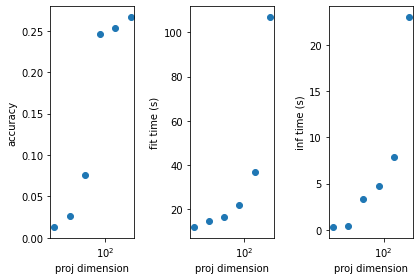

In [55]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3)

for ax_ in ax:
    ax_.set_xscale('log')

ax[0].scatter(n_components_list, accuracies)
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('proj dimension')

# fig, ax = plt.subplots(1,3)
ax[1].scatter(n_components_list, fit_times)
ax[1].set_ylabel('fit time (s)')
ax[1].set_xlabel('proj dimension')

# fig, ax = plt.subplots(1,3)
ax[2].scatter(n_components_list, inf_times)
ax[2].set_ylabel('inf time (s)')
ax[2].set_xlabel('proj dimension')

plt.tight_layout()

In [38]:
n_neighbors_list = [1,2,4,8,16,32,64]

f_tuples = []
for i, n_neighbors in enumerate(n_neighbors_list):
    f_tuples.append({'n_estimators':1, 'p_inbag':1, 
          'projector':'gaussian', 'projection_kwargs':{'n_components': 64}, 
          'affinity':'euclidean', 'linkage':'average', 'n_neighbors':n_neighbors,
          'max_tree_distance':400, 'n_jobs':50})
        
acc_fit_inf2 = Parallel(n_jobs=90)(delayed(benchmark)(f) for f in f_tuples)

In [39]:
accuracies2 = np.zeros(len(n_neighbors_list))
for i, triple in enumerate(acc_fit_inf2):
    accuracies2[i] = triple[0]

Text(0.5, 0, 'n neighbors')

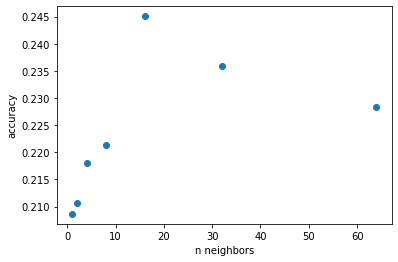

In [40]:
fig, ax = plt.subplots(1,1)
ax.scatter(n_neighbors_list, accuracies2)
ax.set_ylabel('accuracy')
ax.set_xlabel('n neighbors')

In [37]:
n_estimators_list = [1,5,10,20,50,100]

f_tuples = []
for i, n_estimators in enumerate(n_estimators_list):
    f_tuples.append({'n_estimators':n_estimators, 'p_inbag':1, 
          'projector':'gaussian', 'projection_kwargs':{'n_components': 64}, 
          'affinity':'euclidean', 'linkage':'average', 'n_neighbors':8,
          'max_tree_distance':400, 'n_jobs':10})
        
acc_fit_inf3 = Parallel(n_jobs=1)(delayed(benchmark)(f) for f in f_tuples)

0.24228915662650602 35.35033392906189 6.308876276016235
0.3313253012048193 33.73533797264099 33.062217712402344
0.3532128514056225 33.273711919784546 69.16486120223999
0.3561847389558233 43.624093770980835 141.32757186889648
0.3704819277108434 110.14137530326843 360.1992063522339
0.38068273092369476 231.6118426322937 711.724152803421


In [20]:
accuracies3 = np.zeros(len(n_neighbors_list))
for i, triple in enumerate(acc_fit_inf3):
    accuracies3[i] = triple[0]

IndexError: index 5 is out of bounds for axis 0 with size 5

In [ ]:
fig, ax = plt.subplots(1,1)
ax.scatter(n_estimators_list, accuracies3)
ax.set_ylabel('accuracy')
ax.set_xlabel('n estimators')

In [21]:
f_tuples

[{'n_estimators': 100,
  'p_inbag': 1,
  'projector': 'gaussian',
  'projection_kwargs': {'n_components': 128},
  'affinity': 'euclidean',
  'linkage': 'average',
  'n_neighbors': 4,
  'max_tree_distance': 400,
  'n_jobs': 10},
 {'n_estimators': 100,
  'p_inbag': 1,
  'projector': 'gaussian',
  'projection_kwargs': {'n_components': 128},
  'affinity': 'euclidean',
  'linkage': 'average',
  'n_neighbors': 4,
  'max_tree_distance': 400,
  'n_jobs': 10},
 {'n_estimators': 100,
  'p_inbag': 1,
  'projector': 'gaussian',
  'projection_kwargs': {'n_components': 128},
  'affinity': 'euclidean',
  'linkage': 'average',
  'n_neighbors': 4,
  'max_tree_distance': 400,
  'n_jobs': 10},
 {'n_estimators': 100,
  'p_inbag': 1,
  'projector': 'gaussian',
  'projection_kwargs': {'n_components': 128},
  'affinity': 'euclidean',
  'linkage': 'average',
  'n_neighbors': 4,
  'max_tree_distance': 400,
  'n_jobs': 10},
 {'n_estimators': 100,
  'p_inbag': 1,
  'projector': 'gaussian',
  'projection_kwargs':